In [1]:
import numpy as np
import numpy.matlib
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [2]:
def calc_loss_raw(tmp,labels):
    tmp = tmp/np.expand_dims(np.sum(tmp,axis=1),1); # renormalize
    tmp[tmp<1e-15] = 1e-15;
    tmp[tmp>1-1e-15]=1-1e-15;
    myloss = 0;
    for jj in range(9):
        thisclass = labels==jj;
        tmptmp = tmp[:,jj];
        myloss += np.sum(np.log(tmptmp[thisclass]))
    myloss = -myloss/len(labels)
    return myloss;

def calc_loss(submission,labels):
    tmp = submission.to_numpy()
    return calc_loss_raw(tmp,labels);

In [3]:
data_train = pd.read_csv('train.csv');
data_train.set_index(['id'],inplace=True);

# outlier via TSNE
ind = 6549;
data_train.drop(ind,inplace=True);

data_test = pd.read_csv('test.csv');
data_test.set_index(['id'],inplace=True);
data_train['target'] = data_train['target'].apply(lambda s:int(s[-1])-1)

In [4]:
X_train = data_train.copy().drop('target',axis=1);
X_train_log = X_train.copy();
y_train = data_train['target'];

X_test = data_test.copy();
X_test_log = X_test.copy();

from sklearn.preprocessing import StandardScaler;
from sklearn.pipeline import Pipeline;

def munge_combo(df):
    for col in df.columns:
        df[col+'binary'] = 1.0*(df[col]>0);
        df[col+'log'] = np.log1p(df[col]);

munge_combo(X_train);
munge_combo(X_test);

from sklearn.model_selection import train_test_split
X,X_valid,y,y_valid = train_test_split(X_train,y_train,test_size=.3,random_state=10,stratify=y_train);

# Testing three regressors

In [5]:
from lightgbm import LGBMClassifier

myLGBM = LGBMClassifier(reg_alpha=60.0,n_estimators=200)
myLGBM.fit(X,y);

In [51]:
y_predict_proba_lgbm = myLGBM.predict_proba(X);
y_valid_predict_proba_lgbm = myLGBM.predict_proba(X_valid);

print('Train loss = %f'%(calc_loss_raw(y_predict_proba_lgbm,y)))
print('Valid loss = %f'%(calc_loss_raw(y_valid_predict_proba_lgbm,y_valid)));

Train loss = 1.701002
Valid loss = 1.745673


In [31]:
from xgboost import XGBClassifier
myXGB = XGBClassifier(n_estimators=105,reg_lambda=1000.,max_depth=2,use_label_encoder=False);
myXGB.fit(X,y,eval_metric='mlogloss');
mymodel = myXGB;

In [52]:
# n_estimators=105
y_predict_proba_xgb = myXGB.predict_proba(X);
y_valid_predict_proba_xgb = myXGB.predict_proba(X_valid);

print('Train loss = %f'%(calc_loss_raw(y_predict_proba_xgb,y)))
print('Valid loss = %f'%(calc_loss_raw(y_valid_predict_proba_xgb,y_valid)));

Train loss = 1.740998
Valid loss = 1.749375


In [9]:
from sklearn.linear_model import LogisticRegression
myLogisticRegression = LogisticRegression(max_iter=2000,solver='lbfgs',C=0.004);
myLogisticRegression.fit(X,y);

In [53]:
# C=0.004
y_predict_proba_logistic = myLogisticRegression.predict_proba(X);
y_valid_predict_proba_logistic = myLogisticRegression.predict_proba(X_valid);

print('Train loss = %f'%(calc_loss_raw(y_predict_proba_logistic,y)))
print('Valid loss = %f'%(calc_loss_raw(y_valid_predict_proba_logistic,y_valid)));

Train loss = 1.744016
Valid loss = 1.750609


# Blending with arithmetic averaging

## Blending two at a time...

minimum=1.74482, minimizer=0.703382
1.7493745239257812


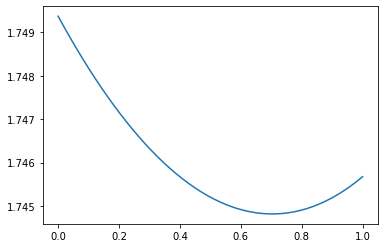

In [54]:
# arithmetic average
blend = lambda cc:(1.0-cc)*y_valid_predict_proba_xgb + cc*y_valid_predict_proba_lgbm;
blendratio = lambda cc:calc_loss_raw(blend(cc),y_valid);

res = minimize(blendratio,0.9)
print('minimum=%g, minimizer=%g'%(res.fun,res.x))

ccs = np.linspace(0,1);
plt.plot(ccs,[blendratio(cc) for cc in ccs])
print(calc_loss_raw(y_valid_predict_proba_xgb,y_valid))

## Blending all three

In [55]:
blend = lambda cc: (1.0-cc[0]-cc[1])*y_valid_predict_proba_xgb + cc[0]*y_valid_predict_proba_logistic + cc[1]*y_valid_predict_proba_lgbm;
blendratio = lambda cc: calc_loss_raw(blend(cc),y_valid);

res = minimize(blendratio,[0.33, 0.33])

weights = list(100*res.x);
weights.insert(0,100.-np.sum(weights));
print(res.fun);
print('xgb:%0.2f%%, logistic:%0.2f%%, lgbm:%0.2f%%'%tuple(weights))
#blendratio([0.2,0.2])

1.7441982544116321
xgb:6.46%, logistic:28.34%, lgbm:65.20%


# Ensemble

I found that it was most effective to stack the regressors in order of best-to-worst, with the final regressor achieving the best loss and having the most weight when arithmetically averaged for optimal blending loss.

In [20]:
from sklearn.ensemble import StackingClassifier

myStack = StackingClassifier( [('logistic',myLogisticRegression),('xgb',myXGB)],
                             cv=3, stack_method='predict_proba',
                             final_estimator=myLGBM,passthrough=True)
myStack.fit(X,y);

[20:55:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:58:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:59:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:59:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

In [50]:
y_valid_predict_proba = myStack.predict_proba(X_valid);
print('Stacked Ensemble loss = %f'%(calc_loss_raw(y_valid_predict_proba,y_valid)))

Stacked Ensemble loss=1.743608


## Stacking ensemble loss is better than just arithmetic blending.

In [ ]:
myStack.fit(X_train,y_train);

In [ ]:
mysubmission = myStack.predict_proba(X_test);

#mysubmission = make_submission(y_test_predict,X_test,ep=0.07412432);
mysubmission = pd.DataFrame(mysubmission);
mysubmission.set_index(X_test.index,inplace=True);
mysubmission.columns = ['Class_'+str(jj) for jj in range(1,10)]
mysubmission.to_csv('submission13.csv',index=True);